In [28]:
from pyspark.sql import SparkSession

spark_session = SparkSession\
    .builder\
    .master("spark://192.168.2.156:7077") \
    .appName("ProjectGR25")\
    .config("spark.pyspark.python", "/home/bogdan/.local/bin/python3")\
    .config("spark.eventLog.enabled", "true")\
    .config("spark.eventLog.dir", "/tmp/spark-logs")\
    .config("spark.dynamicAllocation.enabled", True)\
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True)\
    .config("spark.shuffle.service.enabled", False)\
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s")\
    .config("spark.executor.cores", 2)\
    .config("spark.executor.instances", 4)\
    .config("spark.driver.cores", 2)\
    .config("spark.driver.port", 9999)\
    .config("spark.blockManager.port", 10005)\
    .getOrCreate()


spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")


ConnectionRefusedError: [Errno 111] Connection refused

In [2]:
# Read CSV from hdfs
df = spark_session.read.csv("hdfs://192.168.2.251:9000/data/MillionSongSubset.csv", header=True, inferSchema=True)

# Print Data Frame
df.show()

+--------------------+------------------+--------------------+--------------------+--------------------+-------+-------------------+---------+-------+---+----+--------+------------+------+----+
|           File Path|           Song ID|               Title|              Artist|             Release|  Genre|    Song Hotttnesss| Duration|  Tempo|Key|Mode|Loudness|Danceability|Energy|Year|
+--------------------+------------------+--------------------+--------------------+--------------------+-------+-------------------+---------+-------+---+----+--------+------------+------+----+
|MillionSongSubset...|SOBUDOC12A6D4F8AC2|After All The Lov...|               Alias|               Alias|Unknown|0.38293509007501925|256.67873|120.093|  0|   1| -10.223|         0.0|   0.0|   0|
|MillionSongSubset...|SOLMCFH12A58A7FACE|   Under The Weather|         KT Tunstall|Eye To The Telescope|Unknown| 0.6944535460616664| 216.5024|142.121|  7|   1|  -9.911|         0.0|   0.0|2004|
|MillionSongSubset...|SOOUBMT1

In [9]:
from pyspark.sql.functions import col, count, when

missing_values = df.select([
    count(when(col(c).isNull(), c)).alias(c) for c in df.columns
])
missing_values.show()

# Danceability 0 for the whole dataset
print(df.filter(df.Danceability == 0).count())

# Energy 0 for the whole dataset
print(df.filter(df.Energy == 0).count())

# Some of the years are missing
print(df.filter(df.Year == 0).count())

# Genre is Unknown for the whole dataset
print(df.filter(df.Genre == "Unknown").count())

+---------+-------+-----+------+-------+-----+---------------+--------+-----+---+----+--------+------------+------+----+
|File Path|Song ID|Title|Artist|Release|Genre|Song Hotttnesss|Duration|Tempo|Key|Mode|Loudness|Danceability|Energy|Year|
+---------+-------+-----+------+-------+-----+---------------+--------+-----+---+----+--------+------------+------+----+
|        0|      0|    1|     0|      0|    0|           4352|       0|    0|  0|   0|       0|           0|     0|   0|
+---------+-------+-----+------+-------+-----+---------------+--------+-----+---+----+--------+------------+------+----+

10000
10000
5320
10000


In [12]:
# Drop rows that do not give any information 
df = df.drop("Genre", "Danceability", "Energy")
df.show(5)

+--------------------+------------------+--------------------+------------------+--------------------+-------------------+---------+-------+---+----+--------+----+
|           File Path|           Song ID|               Title|            Artist|             Release|    Song Hotttnesss| Duration|  Tempo|Key|Mode|Loudness|Year|
+--------------------+------------------+--------------------+------------------+--------------------+-------------------+---------+-------+---+----+--------+----+
|MillionSongSubset...|SOBUDOC12A6D4F8AC2|After All The Lov...|             Alias|               Alias|0.38293509007501925|256.67873|120.093|  0|   1| -10.223|   0|
|MillionSongSubset...|SOLMCFH12A58A7FACE|   Under The Weather|       KT Tunstall|Eye To The Telescope| 0.6944535460616664| 216.5024|142.121|  7|   1|  -9.911|2004|
|MillionSongSubset...|SOOUBMT12A8C13DB6D|                90er|        Headliners|  Das Album zum Film|               NULL|347.79383|170.041|  8|   1|  -4.281|2006|
|MillionSongSubs

In [13]:
Correlation_columns_df = df.select("Tempo", "Duration", "Loudness", "Key", "Mode", "Song Hotttnesss")

In [14]:
# Convert to pandas and Correlation matrix
Correlation_columns_df_pd = Correlation_columns_df.toPandas() 
correlation_matrix = Correlation_columns_df_pd.corr()
print(correlation_matrix)

                    Tempo  Duration  Loudness       Key      Mode  \
Tempo            1.000000 -0.009968  0.179354  0.009821 -0.015578   
Duration        -0.009968  1.000000  0.057247  0.015262 -0.049486   
Loudness         0.179354  0.057247  1.000000  0.050274 -0.045518   
Key              0.009821  0.015262  0.050274  1.000000 -0.172049   
Mode            -0.015578 -0.049486 -0.045518 -0.172049  1.000000   
Song Hotttnesss  0.079031  0.007042  0.226461  0.025952 -0.036909   

                 Song Hotttnesss  
Tempo                   0.079031  
Duration                0.007042  
Loudness                0.226461  
Key                     0.025952  
Mode                   -0.036909  
Song Hotttnesss         1.000000  


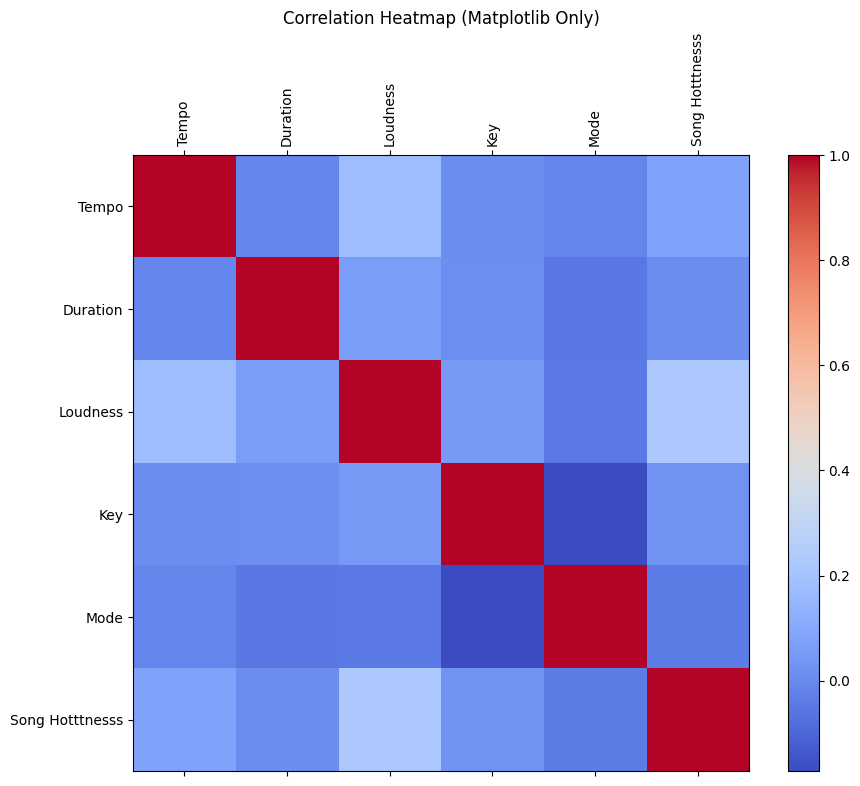

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Plot matrix
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(correlation_matrix, cmap="coolwarm")
plt.colorbar(cax)

ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.index)))

ax.set_xticklabels(correlation_matrix.columns, rotation=90)
ax.set_yticklabels(correlation_matrix.index)

plt.title("Feature Correlation")
plt.show()


In [27]:
# Drop duplicates
df = df.dropDuplicates()


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/home/bogdan/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/bogdan/.local/lib/python3.10/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/bogdan/.local/lib/python3.10/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


Py4JError: An error occurred while calling o482.dropDuplicates